# [**Ajustement croisé interne du TargetEncoder**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/6_3_preprocessing/plot_target_encoder_cross_val.ipynb)<br/>([_Target Encoder’s Internal Cross fitting_](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_target_encoder_cross_val.html))

Le [**`TargetEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html) remplace chaque catégorie d'une caractéristique catégorielle par la moyenne de la variable cible pour cette catégorie. Cette méthode est utile dans les cas où il existe une forte relation entre la caractéristique catégorielle et la cible. Pour éviter le surajustement, [**`TargetEncoder.fit_transform`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder.fit_transform) utilise un schéma d'ajustement croisé interne pour encoder les données d'entraînement à utiliser par un modèle aval. Dans cet exemple, nous illustrons l'importance de la procédure d'ajustement croisé pour prévenir le surajustement.

# Création d'un ensemble de données synthétique

Pour cet exemple, nous construisons un ensemble de données avec trois caractéristiques catégorielles : une caractéristique informative de cardinalité moyenne, une caractéristique non informative de cardinalité moyenne et une caractéristique non informative de grande cardinalité. Tout d'abord, nous générons la caractéristique informative :

In [1]:
import numpy as np

from sklearn.preprocessing import KBinsDiscretizer

n_samples = 50_000

rng = np.random.RandomState(42)
y = rng.randn(n_samples)
noise = 0.5 * rng.randn(n_samples)
n_categories = 100

kbins = KBinsDiscretizer(
    n_bins=n_categories, encode="ordinal", strategy="uniform", random_state=rng
)
X_informative = kbins.fit_transform((y + noise).reshape(-1, 1))

# Remove the linear relationship between y and the bin index by permuting the values of
# X_informative
permuted_categories = rng.permutation(n_categories)
X_informative = permuted_categories[X_informative.astype(np.int32)]

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


La caractéristique non informative de cardinalité moyenne est générée en permutant la caractéristique informative et en supprimant la relation avec la variable cible :

In [2]:
X_shuffled = rng.permutation(X_informative)

La caractéristique non informative de grande cardinalité est générée de manière à être indépendante de la variable cible. Nous montrerons que l'encodage par cible sans ajustement croisé entraînera un surajustement catastrophique pour le modèle de régression aval. Ces caractéristiques de grande cardinalité sont essentiellement des identifiants uniques pour les échantillons, qui devraient généralement être supprimés de l'ensemble de données d'apprentissage automatique. Dans cet exemple, nous les générons pour montrer comment le comportement d'ajustement croisé par défaut de [**`TargetEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html) atténue automatiquement le problème de surajustement.

In [3]:
X_near_unique_categories = rng.choice(
    int(0.9 * n_samples), size=n_samples, replace=True
).reshape(-1, 1)

Enfin, nous assemblons l'ensemble de données et effectuons une division en ensembles d'entraînement et de test :

In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split

X = pd.DataFrame(
    np.concatenate(
        [X_informative, X_shuffled, X_near_unique_categories],
        axis=1,
    ),
    columns=["informative", "shuffled", "near_unique"],
)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Entraînement d'un régresseur Ridge

Dans cette section, nous entraînons un régresseur Ridge sur l'ensemble de données avec et sans encodage, et explorons l'influence de l'encodeur de cible avec et sans ajustement croisé interne. Tout d'abord, nous constatons que le modèle Ridge entraîné sur les caractéristiques brutes aura une faible performance, car l'ordre de la caractéristique informative n'est pas informatif :

In [5]:
import sklearn
from sklearn.linear_model import Ridge

# Configure transformers to always output DataFrames
sklearn.set_config(transform_output="pandas")

ridge = Ridge(alpha=1e-6, solver="lsqr", fit_intercept=False)

raw_model = ridge.fit(X_train, y_train)
print("Raw Model score on training set: ", raw_model.score(X_train, y_train))
print("Raw Model score on test set: ", raw_model.score(X_test, y_test))

Raw Model score on training set:  0.0049896314219657345
Raw Model score on test set:  0.0045776215813679855


Ensuite, nous créons un pipeline avec l'encodeur de cible et le modèle Ridge. Le pipeline utilise **TargetEncoder.fit_transform** qui utilise l'ajustement croisé. Nous constatons que le modèle s'adapte bien aux données et généralise bien à l'ensemble de test :

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import TargetEncoder

model_with_cv = make_pipeline(TargetEncoder(random_state=0), ridge)
model_with_cv.fit(X_train, y_train)
print("Model with CV on training set: ", model_with_cv.score(X_train, y_train))
print("Model with CV on test set: ", model_with_cv.score(X_test, y_test))

Model with CV on training set:  0.800018467746029
Model with CV on test set:  0.7927845601690929


Les coefficients du modèle linéaire montrent que la plupart du poids est sur la caractéristique à l'indice de colonne 0, qui est la caractéristique informative.

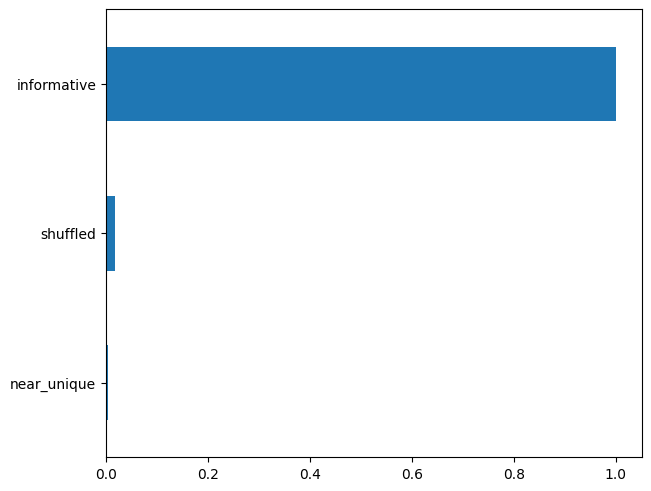

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.constrained_layout.use"] = True

coefs_cv = pd.Series(
    model_with_cv[-1].coef_, index=model_with_cv[-1].feature_names_in_
).sort_values()
_ = coefs_cv.plot(kind="barh")

Alors que [**`TargetEncoder.fit_transform`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder.fit_transform) utilise un schéma d'ajustement croisé interne, [**`TargetEncoder.transform`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder.transform) lui-même n'effectue aucun ajustement croisé. Il utilise l'agrégation de l'ensemble de formation complet pour transformer les caractéristiques catégorielles. Ainsi, nous pouvons utiliser [**`TargetEncoder.fit`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder.fit) suivi de [**`TargetEncoder.transform`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder.transform) pour désactiver l'ajustement croisé. Cet encodage est ensuite transmis au modèle Ridge.

In [8]:
target_encoder = TargetEncoder(random_state=0)
target_encoder.fit(X_train, y_train)
X_train_no_cv_encoding = target_encoder.transform(X_train)
X_test_no_cv_encoding = target_encoder.transform(X_test)

model_no_cv = ridge.fit(X_train_no_cv_encoding, y_train)

Nous évaluons le modèle sur l'encodage non validé par croisement et nous constatons qu'il y a un surajustement :

In [9]:
print(
    "Model without CV on training set: ",
    model_no_cv.score(X_train_no_cv_encoding, y_train),
)
print(
    "Model without CV on test set: ", model_no_cv.score(X_test_no_cv_encoding, y_test)
)

Model without CV on training set:  0.858486250088675
Model without CV on test set:  0.6338211367109028


Le modèle Ridge surajuste car il attribue plus de poids à la caractéristique de grande cardinalité extrême par rapport à la caractéristique informative.

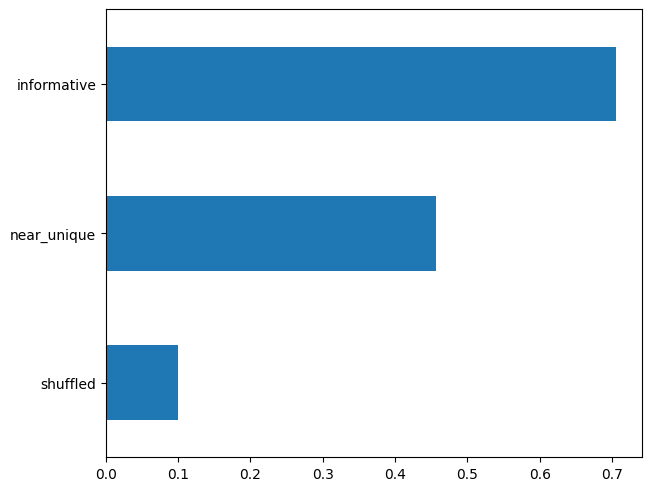

In [10]:
coefs_no_cv = pd.Series(
    model_no_cv.coef_, index=model_no_cv.feature_names_in_
).sort_values()
_ = coefs_no_cv.plot(kind="barh")

# Conclusion

Cet exemple met en évidence l'importance de l'ajustement croisé interne du [**`TargetEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html). Il est important d'utiliser [**`TargetEncoder.fit_transform`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder.fit_transform) pour encoder les données d'entraînement avant de les passer à un modèle d'apprentissage automatique. Lorsqu'un [**`TargetEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html) fait partie d'un [**`Pipeline`**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) et que le pipeline est ajusté, le pipeline appelle correctement [**`TargetEncoder.fit_transform`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder.fit_transform) et transmet l'encodage.